# Import packages

In [82]:

import glob
import os.path
import numpy as np
import mne
import matplotlib.pyplot as plt
import pandas as pd
import yasa

plt.style.use('default')
plt.rc('font', family='Arial')
plt.rc('axes', unicode_minus=False)

mne.set_log_level('CRITICAL')

In [83]:
import dataset

df_info = dataset.load_info()

In [84]:
animal = '0629#'
session = '2024-03-09'
file = os.path.join(dataset.path['tmp'], animal, session, 'raw.edf')

raw = mne.io.read_raw_edf(file, preload=True, verbose=False)
raw.filter(l_freq=0.1, h_freq=30)
group = df_info.loc[animal, 'Genotype']

print(animal, session, group)

0629# 2024-03-09 Mutant


# Reject thr design

In [85]:
raw.set_channel_types({'Loco': 'bio'})
raw.notch_filter(np.arange(50, 100, 50))

thr = 2
annot_muscle, scores_muscle = mne.preprocessing.annotate_muscle_zscore(
    raw,
    ch_type='eeg',
    threshold=thr,
    min_length_good=0.5,
    filter_freq=[110, 120],
)

annot_muscle = annot_muscle[annot_muscle.duration > 3]


In [86]:
def find_over_segs(data, thr, pad=0):
    def _find_terminals(bi_data):
        bi_data[0] = 0
        bi_data[-1] = 0
        bi_bad = np.diff(bi_data)
        bad_start_idx = np.argwhere(bi_bad == 1).reshape(-1)
        bad_end_idx = np.argwhere(bi_bad == -1).reshape(-1)

        return bad_start_idx, bad_end_idx

    flag_bad = np.abs(data) > thr * np.ones(shape=acc.shape)
    bi_bad = np.zeros(shape=acc.shape)
    bi_bad[flag_bad] = 1

    bad_start_idx, bad_end_idx = _find_terminals(bi_bad)

    if pad > 0:
        bad_start_idx = bad_start_idx - pad
        bad_end_idx = bad_end_idx + pad

        bad_start_idx[bad_start_idx < 0] = 0
        bad_end_idx[bad_end_idx > data.size] = data.size

        bi_bad = np.zeros(shape=acc.shape)
        for (start_idx, end_idx) in zip(bad_start_idx, bad_end_idx):
            bi_bad[int(start_idx):int(end_idx)] = 1
            bad_start_idx, bad_end_idx = _find_terminals(bi_bad)

    return bad_start_idx, bad_end_idx, bi_bad

In [87]:
acc = raw.get_data(picks='Loco', units='uV').squeeze()
sf = raw.info['sfreq']
bad_start_idx, bad_end_idx, bi_bad = find_over_segs(acc, 100, pad=sf * 1)

onsets = bad_start_idx / sf
durations = (bad_end_idx - bad_start_idx) / sf
descriptions = ['BAD_loco'] * len(bad_start_idx)
annot_loco = mne.Annotations(
    onsets, durations, descriptions, orig_time=raw.info["meas_date"]
)
raw.set_annotations(raw.annotations + annot_loco + annot_muscle)


Measurement date,"March 09, 2024 17:26:59 GMT"
Experimenter,Unknown
Participant,X
Digitized points,Not available
Good channels,"1 EEG, 1 BIO"
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.10 Hz
Lowpass,30.00 Hz


# Reload annotated data

In [88]:
def _annot_to_mask(raw):
    events_ignore, _ = mne.events_from_annotations(raw, regexp=None)
    events_ignore = events_ignore.astype('int')
    flag_ignore = np.zeros_like(raw.times, dtype='bool')
    for event in events_ignore:
        flag_ignore[event[0]:event[0] + event[1]] = True
    
    return flag_ignore

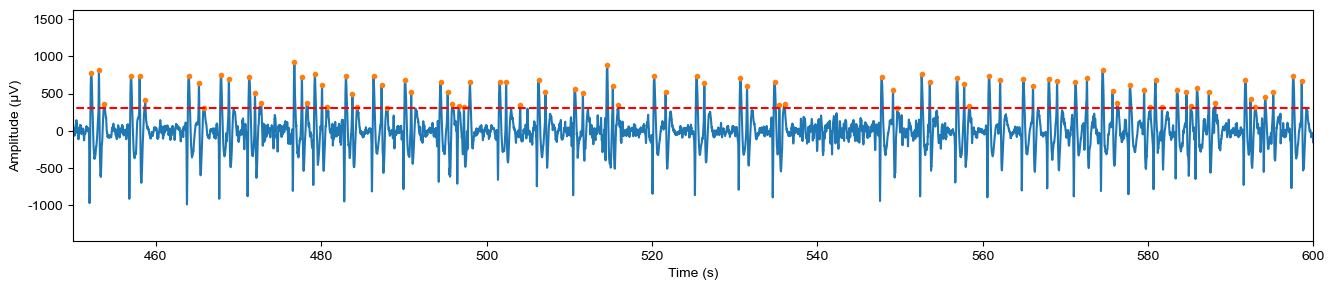

In [89]:
from scipy.signal import find_peaks

thr_muscle = 4
thr_acc = 100

data = raw.copy().filter(0.1, 30).get_data(picks=raw.ch_names[0], units='uV').squeeze()
flag_ignore = _annot_to_mask(raw)
data[flag_ignore] = np.nan
peaks, peak_values = find_peaks(data, height=300, prominence=400)

plt.figure(figsize=(16, 3))

plt.plot(raw.times, data)
plt.plot(peaks / raw.info['sfreq'], data[peaks], "o", markersize=3)
plt.hlines(300, *raw.times[[0, -1]], 'r', '--')
plt.xlim(450, 600)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (μV)')
plt.show()

In [90]:
onsets = peaks / sf
durations = np.zeros_like(peaks)
descriptions = ['spike'] * len(onsets)
annot_spike = mne.Annotations(
    onsets, durations, descriptions, orig_time=raw.info["meas_date"]
)

In [91]:
raw.set_annotations(raw.annotations + annot_spike)
raw.export(raw.filenames[0].replace('.edf', '_spike_detect.edf'), overwrite=True)

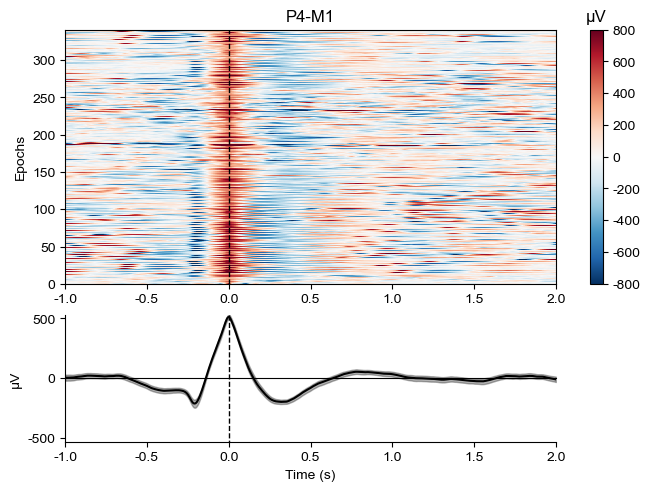

In [92]:
spike_events, event_id = mne.events_from_annotations(raw, event_id={'spike': 1})
epochs = mne.Epochs(raw, spike_events, tmin=-1, tmax=2, event_id=event_id, preload=True)
epochs.plot_image(picks=raw.ch_names[0], vmin=-800, vmax=800)
plt.show()

In [93]:
peak_amp = epochs.average().get_data(units='uV', picks=raw.ch_names[0]).max()
spike_rate = len(epochs) / raw.times[-1]
print(f'Spike rate: {spike_rate:.2f} s^-1; Peak amplitude: {peak_amp:.2f} μV')

Spike rate: 0.17 s^-1; Peak amplitude: 511.33 μV


# Multi-sessions

In [94]:
files = glob.glob(os.path.join(dataset.path['tmp'], '**', 'raw.edf'), recursive=True)


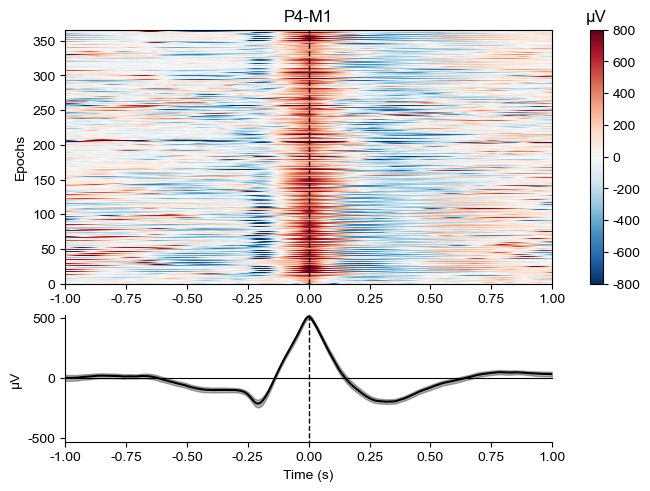

0629# 2024-03-09 Mutant
Spike rate: 0.18 s^-1; Peak amplitude: 512.84 μV
***


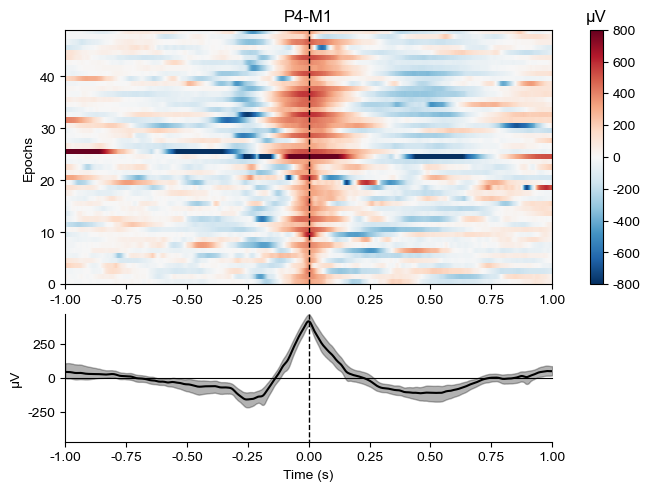

0629# 2024-03-29 Mutant
Spike rate: 0.01 s^-1; Peak amplitude: 418.33 μV
***


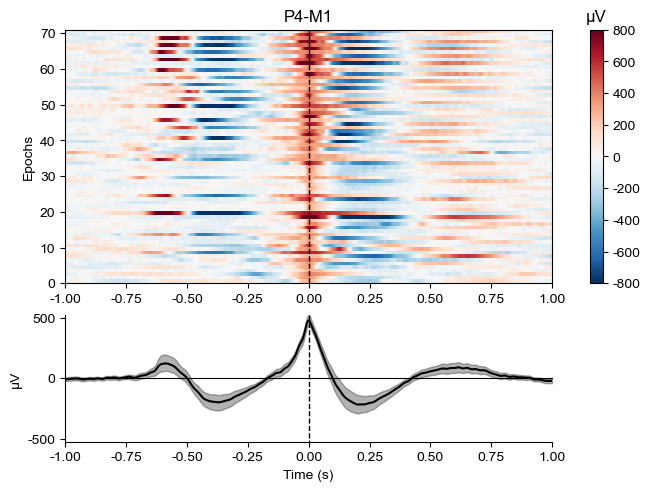

0633# 2024-05-27 WT
Spike rate: 0.01 s^-1; Peak amplitude: 478.66 μV
***


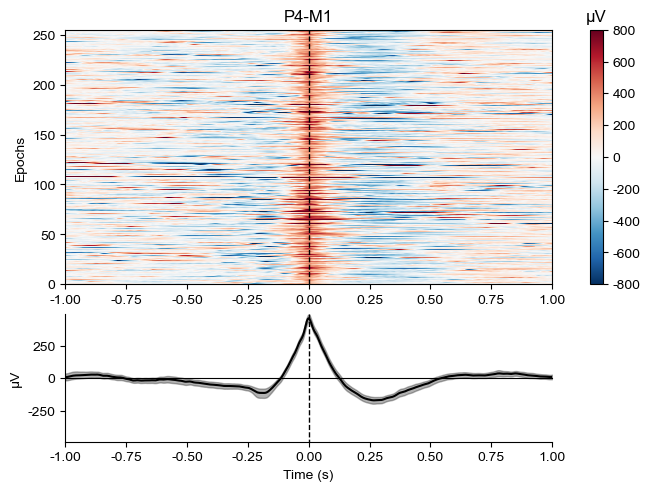

0635# 2024-05-13 Mutant
Spike rate: 0.05 s^-1; Peak amplitude: 460.62 μV
***


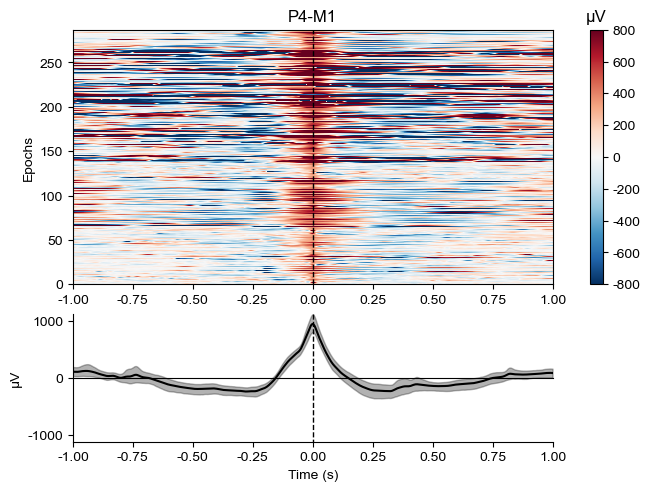

0741# 2024-03-14 Mutant
Spike rate: 0.10 s^-1; Peak amplitude: 951.46 μV
***


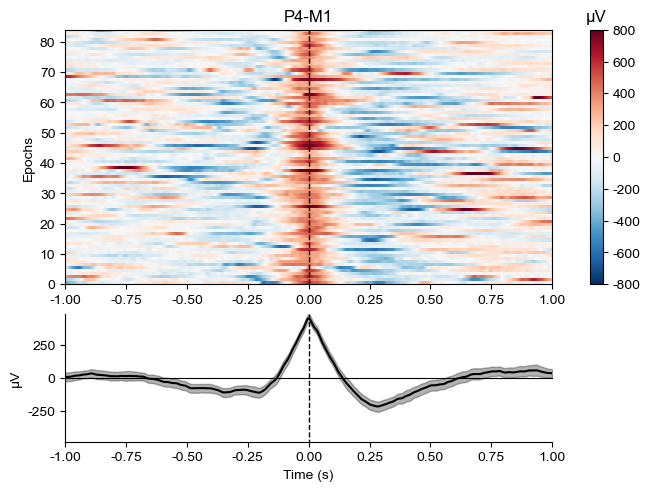

0741# 2024-05-15 Mutant
Spike rate: 0.01 s^-1; Peak amplitude: 453.88 μV
***


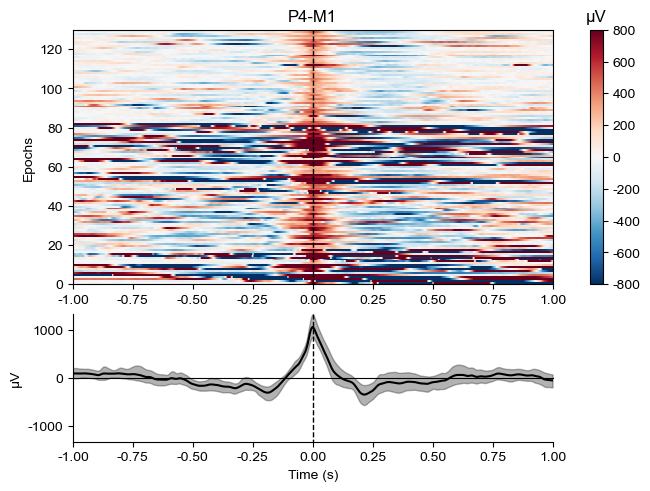

0741# 2024-05-20 Mutant
Spike rate: 0.03 s^-1; Peak amplitude: 1059.26 μV
***


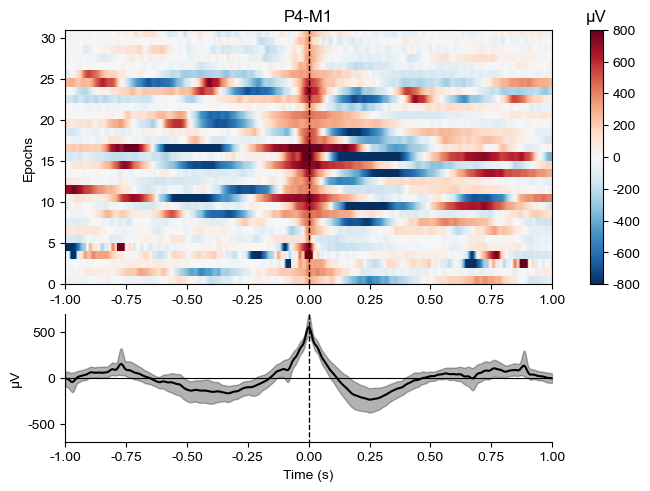

0745# 2024-04-05 WT
Spike rate: 0.01 s^-1; Peak amplitude: 554.25 μV


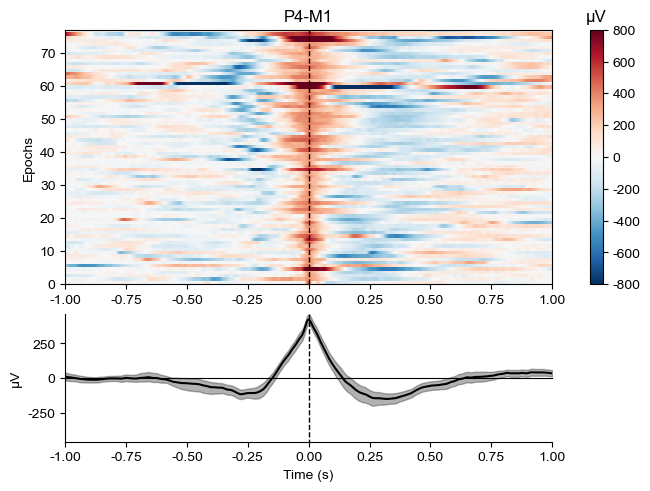

0745# 2024-04-08 WT
Spike rate: 0.02 s^-1; Peak amplitude: 423.68 μV
***


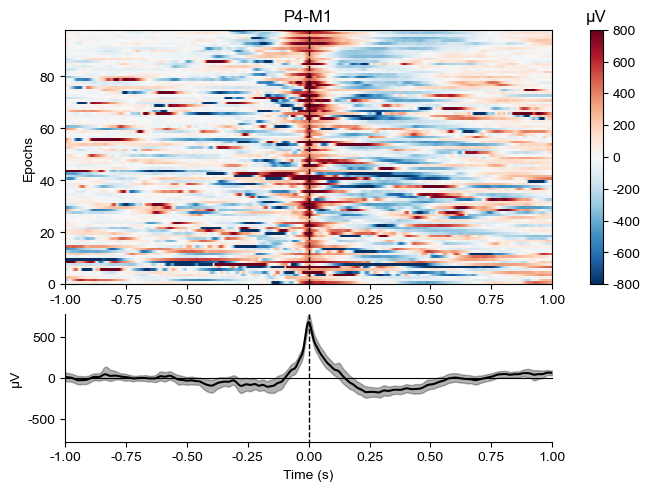

0760# 2024-04-19 Mutant
Spike rate: 0.03 s^-1; Peak amplitude: 686.00 μV
***


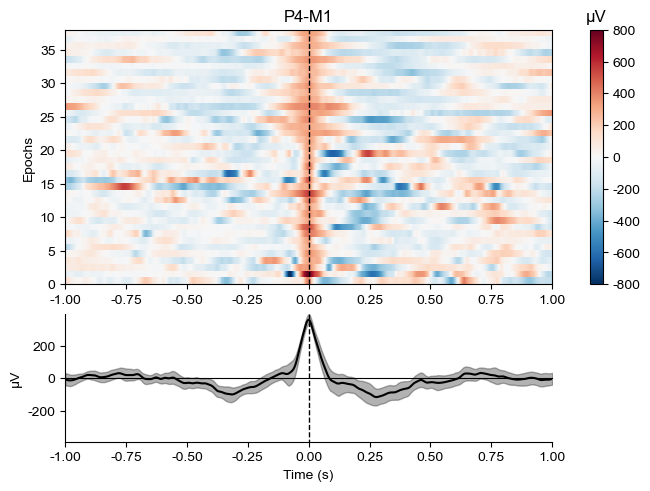

0769# 2024-04-01 WT
Spike rate: 0.01 s^-1; Peak amplitude: 358.52 μV
***


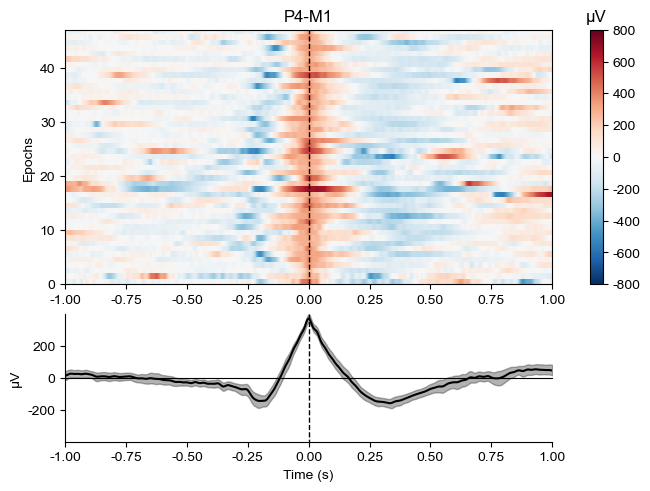

0769# 2024-05-11 WT
Spike rate: 0.01 s^-1; Peak amplitude: 370.48 μV


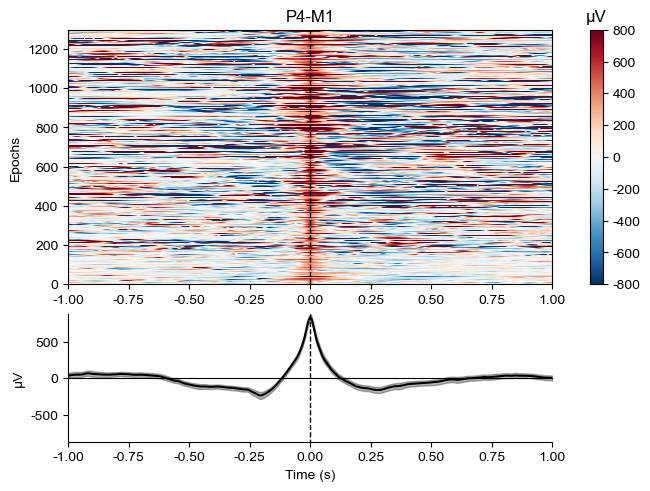

0771# 2024-03-21 Mutant
Spike rate: 0.21 s^-1; Peak amplitude: 828.12 μV
***


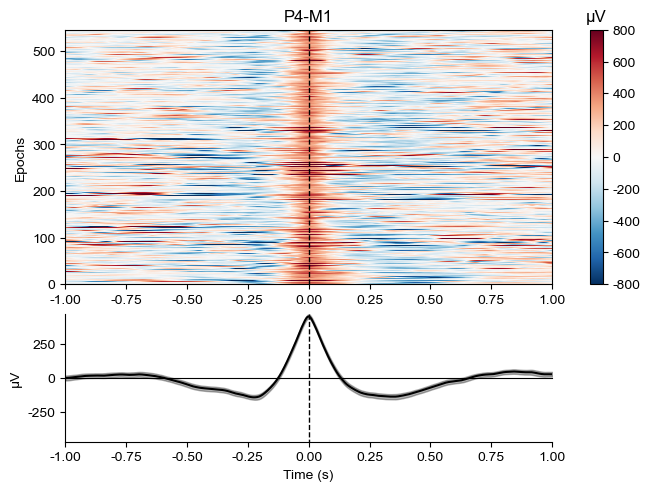

0771# 2024-03-28 Mutant
Spike rate: 0.13 s^-1; Peak amplitude: 449.99 μV
***


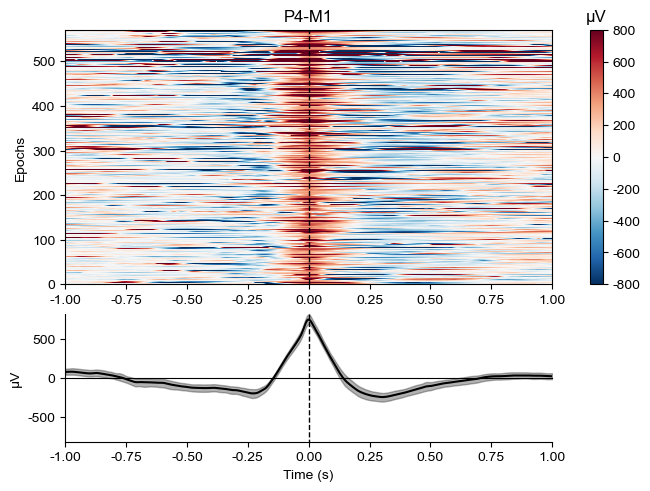

0787# 2024-04-02 WT
Spike rate: 0.14 s^-1; Peak amplitude: 745.78 μV
***


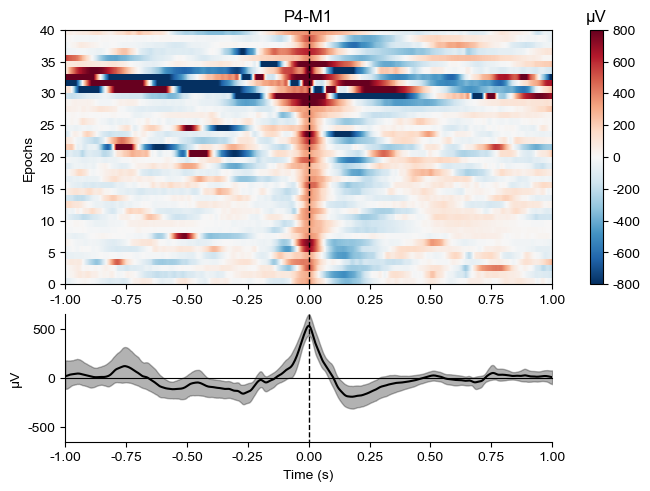

0792# 2024-04-26 WT
Spike rate: 0.01 s^-1; Peak amplitude: 534.99 μV


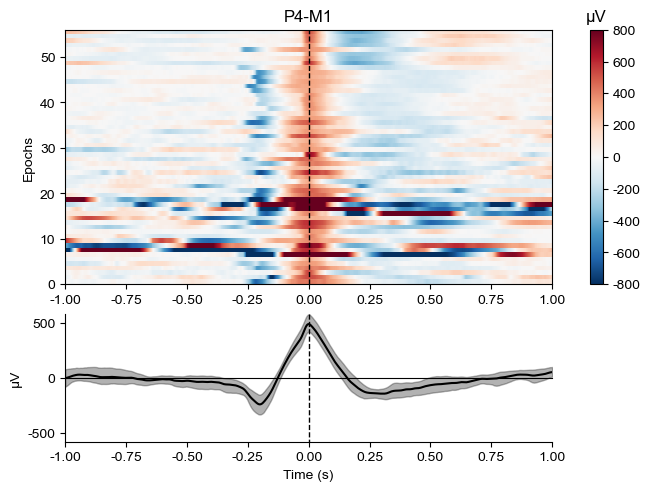

0800# 2024-04-18 Mutant
Spike rate: 0.02 s^-1; Peak amplitude: 488.49 μV
***


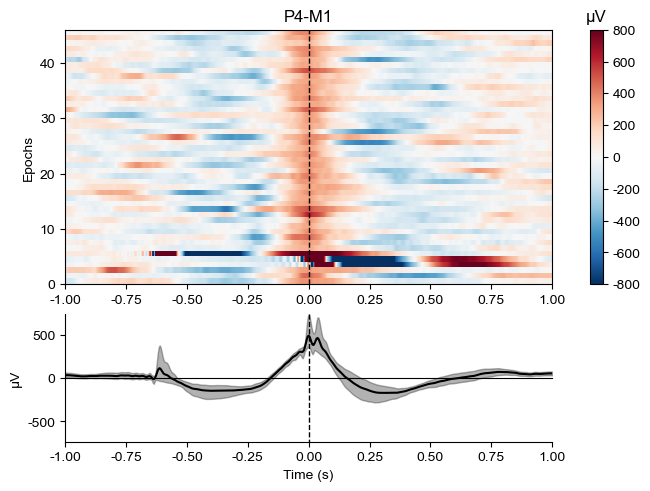

0800# 2024-05-14 Mutant
Spike rate: 0.01 s^-1; Peak amplitude: 489.96 μV


In [96]:
import datetime
from scipy.signal import find_peaks

df_sessions = pd.DataFrame()
df_peak_property = pd.DataFrame()
for file in files:
    animal, session = np.array(file.split('\\'))[[-3, -2]]
    group = df_info.loc[animal, 'Genotype']

    # animal = '0629#'
    # session = '2024-03-09'
    # file = os.path.join(dataset.path['tmp'], animal, session, 'raw.edf')

    raw = mne.io.read_raw_edf(file, preload=True, verbose=False)
    raw.filter(l_freq=0.1, h_freq=30)

    raw.set_channel_types({'Loco': 'bio'})
    raw.notch_filter(np.arange(50, 100, 50))
    
    thr_muscle = 2
    thr_acc = 100
    
    # muscle
    annot_muscle, scores_muscle = mne.preprocessing.annotate_muscle_zscore(
        raw,
        ch_type='eeg',
        threshold=thr,
        min_length_good=0.5,
        filter_freq=[110, 120],
    )
    
    annot_muscle = annot_muscle[annot_muscle.duration > 3]

    # loco
    acc = raw.get_data(picks='Loco', units='uV').squeeze()
    sf = raw.info['sfreq']
    bad_start_idx, bad_end_idx, bi_bad = find_over_segs(acc, thr_acc, pad=sf * 1)

    onsets = bad_start_idx / sf
    durations = (bad_end_idx - bad_start_idx) / sf
    descriptions = ['BAD_loco'] * len(bad_start_idx)
    annot_loco = mne.Annotations(
        onsets, durations, descriptions, orig_time=raw.info["meas_date"]
    )

    data = raw.copy().filter(0.1, 30).get_data(picks=raw.ch_names[0], units='uV').squeeze()
    raw.set_annotations(raw.annotations + annot_loco + annot_muscle)
    
    # spike
    flag_ignore = _annot_to_mask(raw)
    data[flag_ignore] = np.nan
    peaks, properties = find_peaks(data, height=300, prominence=400)

    onsets = peaks / sf
    durations = np.zeros_like(peaks)
    descriptions = ['spike'] * len(onsets)
    annot_spike = mne.Annotations(
        onsets, durations, descriptions, orig_time=raw.info["meas_date"]
    )
    raw.set_annotations(raw.annotations + annot_spike + annot_loco + annot_muscle)
    raw.export(raw.filenames[0].replace('.edf', '_spike_detect.edf'), overwrite=True)
    
    # session table
    session_length = raw.times[-1]
    df_sessions_tmp = pd.DataFrame({
        'animal_id': animal, 
        'genotype':group, 
        'session': session, 
        'session_length': session_length
    }, index=[0])
    df_sessions = pd.concat([df_sessions, df_sessions_tmp])
    
    # spike table
    if peaks.size > 0:
        spike_events, event_id = mne.events_from_annotations(raw, event_id={'spike': 1})
        if spike_events.size > 0:
            epochs = mne.Epochs(raw, spike_events, tmin=-1, tmax=1, event_id=event_id, preload=True)
            if len(epochs) > 30:
                epochs.plot_image(picks=raw.ch_names[0], vmin=-800, vmax=800)
                plt.show()

                peak_amp = epochs.average().get_data(units='uV', picks=raw.ch_names[0]).max()
                spike_rate = len(epochs) / raw.times[-1]
                print(animal, session, group)
                print(f'Spike rate: {spike_rate:.2f} s^-1; Peak amplitude: {peak_amp:.2f} μV')
                if spike_rate > 0.01:
                    print('***')

                peak_onset = epochs.events[:, 0] / sf
                isi = np.zeros_like(peak_onset)
                isi[1:] = np.diff(peak_onset)
                peak_width = (properties['right_bases'] - properties['left_bases']) / sf
                peak_width = peak_width[epochs.selection]
                
                df_peak_property_tmp = pd.DataFrame(properties).loc[epochs.selection, :]
                df_peak_property_tmp = df_peak_property_tmp.drop(df_peak_property_tmp.columns[-2:], axis=1)
                df_peak_property_tmp.insert(0, 'peak_width', peak_width)
                df_peak_property_tmp.insert(0, 'isi', isi)
                df_peak_property_tmp.insert(0, 'peak_onset', peak_onset)
                df_peak_property_tmp.insert(0, 'session_length', session_length)
                df_peak_property_tmp.insert(0, 'genotype', group)
                df_peak_property_tmp.insert(0, 'session', session)
                df_peak_property_tmp.insert(0, 'animal_id', animal)

                df_peak_property = pd.concat([df_peak_property, df_peak_property_tmp])

    else:
        spike_rate = 0
        peak_amp = 0



In [98]:
df_peak_property.to_excel(os.path.join(dataset.path['results'], 'spike_detect.xlsx'))
df_sessions = df_sessions.reset_index(drop=True)
df_sessions.to_excel(os.path.join(dataset.path['results'], 'sessions.xlsx'))